In [1]:
from pyspark.sql import SparkSession
#from pyspark.sql.functions import *
from pyspark.sql import functions as F
#from googletrans import Translator
from pyspark.sql.window import Window
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#from mpl_toolkits.basemap import Basemap
import time
import re

spark = SparkSession \
    .builder \
    .appName("Large scale human mobility data analysis through social media") \
    .config("spark.sql.broadcastTimeout", "36000") \
    .getOrCreate()

twitter_df = spark.read.load("/data/twitterdata/UserTweetInEurope_df.parquet", format="parquet")
instagram_df = spark.read.load("/data/instagramdata/instagram_df.parquet", format="parquet")

twitter_df.createOrReplaceTempView("twitter")
instagram_df.createOrReplaceTempView("instagram")

In [3]:
#language can be automatically detected by Twitter, Instagram cannot
twitter_df.createOrReplaceTempView("twitter")
plt.rcParams["figure.figsize"] = (18, 6)
##plot tweet counts by languag
lang = spark.sql("select lang,count(distinct media_id) from twitter where lang is not null group by lang order by (count(distinct media_id)) desc limit 50")
lang_rdd = lang.rdd.map(lambda row: (row[0], row[1]))
lang_array_lang = lang_rdd.map(lambda p: p[0]).collect()
X = np.arange(len(lang_array_lang))
lang_array_count = lang_rdd.map(lambda p: p[1]).collect()

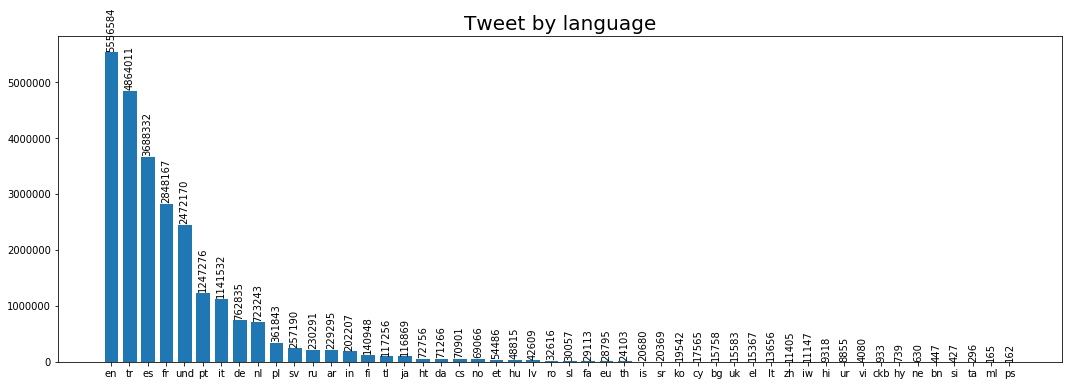

In [4]:
plt.bar(X, lang_array_count, width=0.8, edgecolor='white', align='center')

plt.title('Tweet by language', size=20)

for a, b in zip(X, lang_array_count):
    plt.text(a, b, str(b), ha='center', va='bottom',rotation = 90)

plt.xticks(X, lang_array_lang)
plt.savefig('../Figures/Tweet_by_language3.eps', format='eps',bbox_inches='tight',transparent=True)
# plt.xlabel('language',size=15)
# plt.ylabel('Tweet_count',size=15)
plt.show()

In [2]:
#prepare the data for twitter user of country
plt.rcParams["figure.figsize"] = (18, 6)
twitter_user_country_count = spark.sql("select distinct user_id,country_code,count(distinct media_id) as count from twitter where country_code is not null group by user_id,country_code" )
twitter_user_country_count.createOrReplaceTempView("user_country_count")
twitter_user_country_residence = spark.sql("select distinct user_id,country_code from user_country_count where count in (select max(count) as count from user_country_count group by user_id)")
twitter_user_country_residence.createOrReplaceTempView("twitter_user_country_residence")
twitter_user_by_country = spark.sql("select distinct country_code, count(distinct user_id) as users from twitter_user_country_residence group by country_code order by users desc limit 50")
twitter_user_by_country.createOrReplaceTempView("twitter_user_by_country")
twitter_user_by_country_rdd = twitter_user_by_country.rdd.map(lambda row: (row[0], row[1]))
twitter_country1 = twitter_user_by_country_rdd.map(lambda p: p[0]).collect()
X1 = np.arange(len(twitter_country1))
twitter_users1 = twitter_user_by_country_rdd.map(lambda p: p[1]).collect()

In [16]:
#prepare the data for instagram user of country
plt.rcParams["figure.figsize"] = (18, 6)
instagram_user_country_count = spark.sql("select distinct user_id,country_id,count(distinct media_id) as count from instagram where country_id is not null group by user_id,country_id" )
instagram_user_country_count.createOrReplaceTempView("instagram_user_country_count")
instagram_user_country_residence = spark.sql("select distinct user_id,country_id from instagram_user_country_count where count in (select max(count) as count from user_country_count group by user_id)")
instagram_user_country_residence.createOrReplaceTempView("instagram_user_country_residence")
instagram_user_by_country = spark.sql("select distinct country_id, count(distinct user_id) as instagram_users from instagram_user_country_residence group by country_id order by instagram_users desc limit 50")
instagram_user_by_country.createOrReplaceTempView("instagram_user_by_country")

In [40]:
#join the twitter and instagram user of countries
#and then set the x-axis of both twitter and instagram as the desc sequence of twitter users
twitter_instagram_user_by_country = twitter_user_by_country.join(instagram_user_by_country,twitter_user_by_country['country_code']==instagram_user_by_country['country_id']).drop(instagram_user_by_country['country_id'])
twitter_instagram_user_by_country = twitter_instagram_user_by_country.orderBy(twitter_instagram_user_by_country['users'].desc())
twitter_instagram_user_by_country_rdd = twitter_instagram_user_by_country.rdd.map(lambda row: (row[0], row[1],row[2]))
country1 = twitter_instagram_user_by_country_rdd.map(lambda p: p[0]).collect()
X1 = np.arange(len(country1))
twitter_users = twitter_instagram_user_by_country_rdd.map(lambda p: p[1]).collect()
instagram_users = twitter_instagram_user_by_country_rdd.map(lambda p: p[2]).collect()

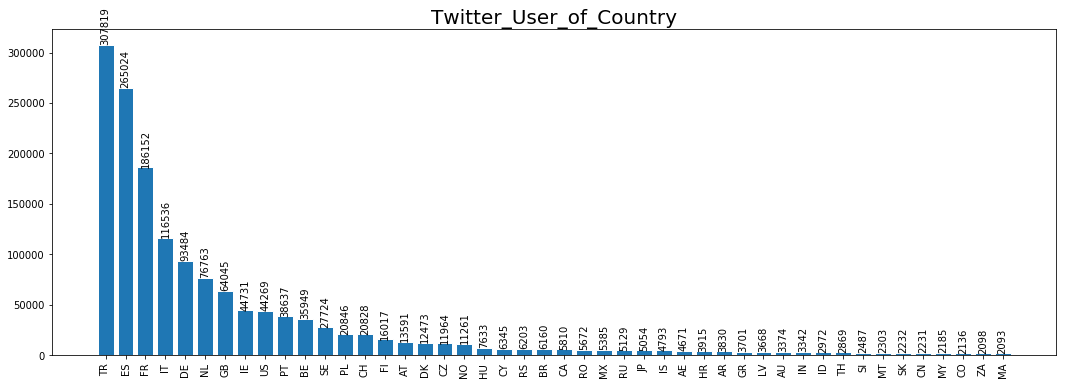

In [71]:
plt.bar(X1, twitter_users, width=0.8, edgecolor='white', align='center')
plt.title('Twitter_User_of_Country', size=20)
for a, b in zip(X1, twitter_users):
    plt.text(a, b, str(b), ha='center', va='bottom',rotation = 90)
#translator = Translator()
#translations = translator.translate(country1)
#country_en = []
#for translation in translations:
#    country_en.append(translation.text)
plt.xticks(X1, country1,rotation=90)
plt.savefig('../Figures/Twitter_User_of_Country3.eps', format='eps',bbox_inches='tight',transparent=True)
plt.show()

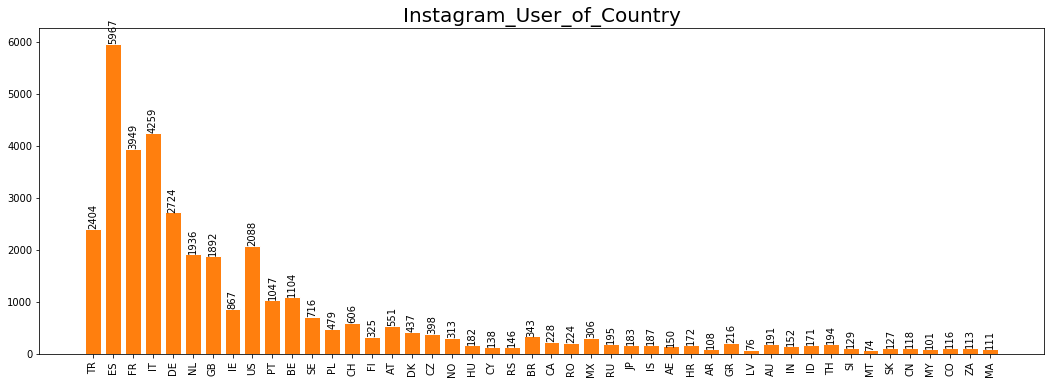

In [75]:
plt.bar(X1, instagram_users, width=0.8, edgecolor='white', align='center',color = 'C1')
plt.title('Instagram_User_of_Country', size=20)
for a, b in zip(X1, instagram_users):
    plt.text(a, b, str(b), ha='center', va='bottom',rotation = 90)
#translator = Translator()
#translations = translator.translate(country1)
#country_en = []
#for translation in translations:
#    country_en.append(translation.text)
plt.xticks(X1, country1,rotation=90)
plt.savefig('../Figures/Instagram_User_of_Country1.eps', format='eps',bbox_inches='tight',transparent=True)
#plt.show()

In [65]:
#prepare the data for twitter mobile user of country
plt.rcParams["figure.figsize"] = (18, 6)
twitter_mobile_user = spark.sql("select distinct user_id from twitter where country_code is not null group by user_id having count(distinct country_code)>1")
twitter_mobile_user.createOrReplaceTempView("twitter_mobile_user")
#mobile_user_by_country = spark.sql("select distinct country_code, count(user_id) as mobile_users from user_country_residence where user_id in (select distinct user_id from mobile_user) group by country_code order by mobile_users desc limit 50")
twitter_mobile_user_by_country = spark.sql("select distinct a.country_code, count(distinct b.user_id) as mobile_users from twitter_user_country_residence a join twitter_mobile_user b on a.user_id = b.user_id group by a.country_code order by mobile_users desc limit 50")
twitter_mobile_user_by_country.createOrReplaceTempView("twitter_mobile_user_by_country")
twitter_mobile_user_percentage = spark.sql("select distinct a.country_code, a.mobile_users/b.users as twitter_mobile_user_percentage from twitter_mobile_user_by_country a join twitter_user_by_country b on a.country_code = b.country_code order by twitter_mobile_user_percentage desc limit 50")
#mobile_user_percentage_rdd = mobile_user_percentage.rdd.map(lambda row: (row[0], row[1],row[2]))
#country2 = mobile_user_percentage_rdd.map(lambda p: p[0]).collect()
#X2 = np.arange(len(country2))
#mobile_user_percentage = mobile_user_percentage_rdd.map(lambda p: p[1]).collect()

In [66]:
#prepare the data for instagram mobile user of country
instagram_mobile_user = spark.sql("select distinct user_id from instagram where country_id is not null group by user_id having count(distinct country_id)>1")
instagram_mobile_user.createOrReplaceTempView("instagram_mobile_user")
#mobile_user_by_country = spark.sql("select distinct country_code, count(user_id) as mobile_users from user_country_residence where user_id in (select distinct user_id from mobile_user) group by country_code order by mobile_users desc limit 50")
instagram_mobile_user_by_country = spark.sql("select distinct a.country_id, count(distinct b.user_id) as mobile_users from instagram_user_country_residence a join instagram_mobile_user b on a.user_id = b.user_id group by a.country_id order by mobile_users desc limit 50")
instagram_mobile_user_by_country.createOrReplaceTempView("instagram_mobile_user_by_country")
instagram_mobile_user_percentage = spark.sql("select distinct a.country_id, a.mobile_users/b.instagram_users as instagram_mobile_user_percentage from instagram_mobile_user_by_country a join instagram_user_by_country b on a.country_id = b.country_id order by instagram_mobile_user_percentage desc limit 50")

In [67]:
##join the twitter and instagram mobile user of countries
#and then set the x-axis of both twitter and instagram as the desc sequence of twitter mobile users
twitter_instagram_mobile_user_percentage = twitter_mobile_user_percentage.join(instagram_mobile_user_percentage,twitter_mobile_user_percentage['country_code']==instagram_mobile_user_percentage['country_id']).drop(instagram_mobile_user_percentage['country_id'])
twitter_instagram_mobile_user_percentage = twitter_instagram_mobile_user_percentage.orderBy(twitter_instagram_mobile_user_percentage['twitter_mobile_user_percentage'].desc())
twitter_instagram_mobile_user_percentage_rdd = twitter_instagram_mobile_user_percentage.rdd.map(lambda row: (row[0], row[1],row[2]))
country2 = twitter_instagram_mobile_user_percentage_rdd.map(lambda p: p[0]).collect()
X2 = np.arange(len(country2))
twitter_mobile_user_percentage = twitter_instagram_mobile_user_percentage_rdd.map(lambda p: p[1]).collect()
instagram_mobile_user_percentage = twitter_instagram_mobile_user_percentage_rdd.map(lambda p: p[2]).collect()

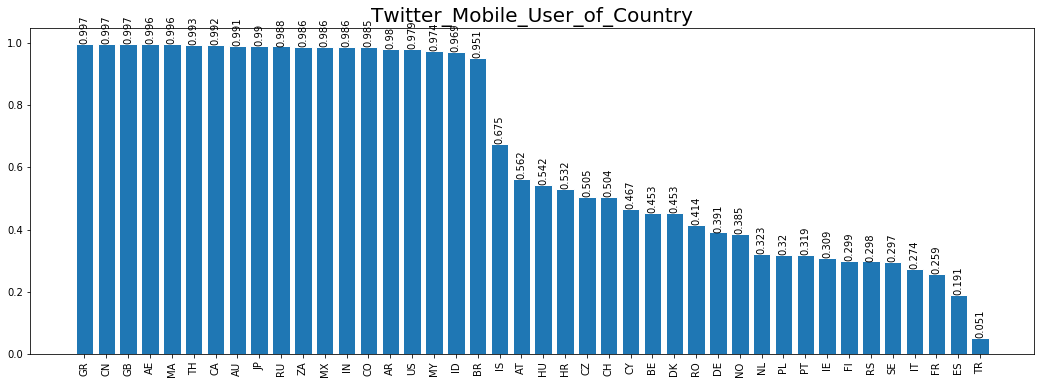

In [76]:
for index, item in enumerate(twitter_mobile_user_percentage):
    twitter_mobile_user_percentage[index] = float("{:.3f}".format(item))

#users_percentage = [user/tweets[0] for user in users]
plt.bar(X2, twitter_mobile_user_percentage, width=0.8, edgecolor='white', align='center')
plt.title('Twitter_Mobile_User_of_Country', size=20)
for a, b in zip(X2, twitter_mobile_user_percentage):
    plt.text(a, b, str(b), ha='center', va='bottom',rotation=90)
plt.xticks(X2, country2,rotation=90)
plt.savefig('../Figures/Twitter_Mobile_User_of_Country2.eps', format='eps',bbox_inches='tight',transparent=True)
plt.show()

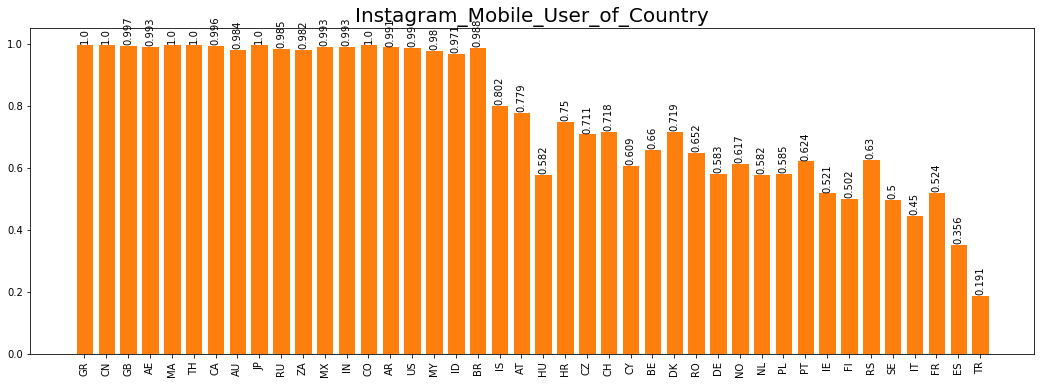

In [77]:
for index, item in enumerate(instagram_mobile_user_percentage):
    instagram_mobile_user_percentage[index] = float("{:.3f}".format(item))
#users = mobile_user_percentage_rdd.map(lambda p: p[2]).collect()
plt.bar(X2, instagram_mobile_user_percentage, width=0.8, edgecolor='white', align='center',color = 'C1')
plt.title('Instagram_Mobile_User_of_Country', size=20)
for a, b in zip(X2, instagram_mobile_user_percentage):
    plt.text(a, b, str(b), ha='center', va='bottom',rotation=90)
plt.xticks(X2, country2,rotation=90)
plt.savefig('../Figures/Instagram_Mobile_User_of_Country1.eps', format='eps',bbox_inches='tight',transparent=True)
plt.show()

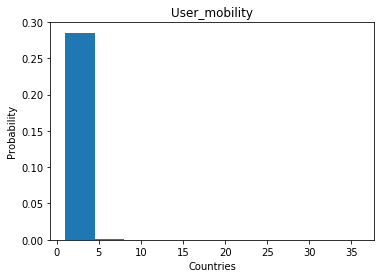

In [3]:
#the number of countries from which users tweet
user_mobility = spark.sql("select distinct user_id,count(distinct country_code) as country from twitter group by user_id order by country desc")
user_mobility_rdd = user_mobility.rdd.map(lambda p: p[1]).collect()
user_id_rdd = user_mobility.rdd.map(lambda p: p[0]).collect()
user_mobility_array= np.asarray(user_mobility_rdd)
num_bins = 10

n, bins, patches = plt.hist(user_mobility_array, num_bins, normed=1)
# add a 'best fit' line  
#y = mlab.normpdf(bins, mu, sigma)  
#plt.plot(bins, y, 'r--') 
plt.xlabel('Countries')  
plt.ylabel('Probability')  
plt.title('User_mobility') 
plt.savefig('../Figures/User_Mobility.eps', format='eps',bbox_inches='tight',transparent=True)
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)  
plt.show()

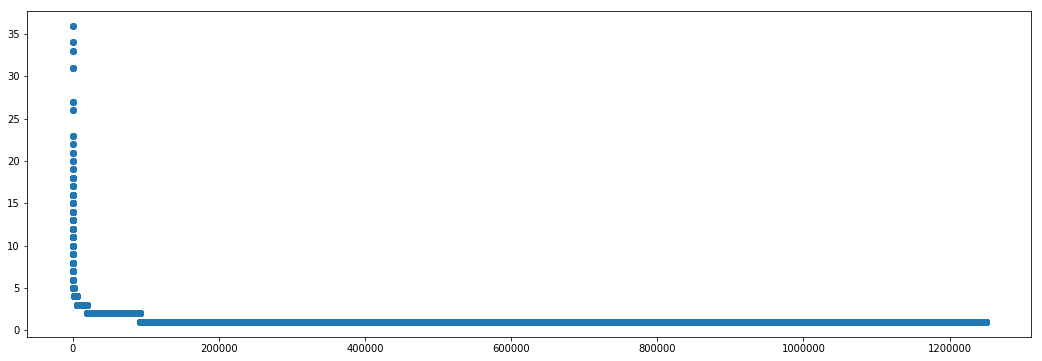

In [30]:
plt.rcParams["figure.figsize"] = (18, 6)
X_user = np.arange(len(user_id_rdd))
plt.scatter(X_user,user_mobility_array)
plt.savefig('../Figures/User_Mobility2.eps', format='eps',bbox_inches='tight',transparent=True)